# Using Pre-trained Word Embeddings

Here we introduce how to use pre-trained word embeddings, where each word is represened by a vector. Two popular word embeddings are GloVe and fastText. The used GloVe and fastText pre-trained word embeddings here are from the following sources:

* GloVe project website：https://nlp.stanford.edu/projects/glove/
* fastText project website：https://fasttext.cc/

Let us first import the following packages used in this example.

In [1]:
from mxnet import gluon
from mxnet import nd
import gluonnlp as nlp
from mxnet import nd
import re

## Creating Vocabulary with Word Embeddings

As a common use case, let us index words, attach pre-trained word embeddings for them, and use such embeddings in Gluon. We will assign a unique ID and word vector to each word in the vocabulary in just a few lines of code.

### Creating Vocabulary from Data Sets

To begin with, suppose that we have a simple text data set in the string format. 

In [2]:
text = " hello world \n hello nice world \n hi world \n"

We need a tokenizer to process this string

In [3]:
def simple_tokenize(source_str, token_delim=' ', seq_delim='\n'):
    return filter(None, re.split(token_delim + '|' + seq_delim, source_str))
counter = nlp.data.count_tokens(simple_tokenize(text))

In [4]:
counter

Counter({'hello': 2, 'world': 3, 'nice': 1, 'hi': 1})

The obtained `counter` has key-value pairs whose keys are words and values are word frequencies. This allows us to filter out infrequent words via `Vocab` arguments such as `max_size` and `min_freq`. Suppose that we want to build indices for all the keys in counter. We need a `Vocab` instance with counter as its argument.

In [5]:
vocab = nlp.Vocab(counter)

To attach word embedding to indexed words in `vocab`, let us go on to create a fastText word embedding instance by specifying the embedding name `fasttext` and the source name `wiki.simple`.

In [6]:
vocab.idx_to_token

['<unk>', '<pad>', '<bos>', '<eos>', 'world', 'hello', 'hi', 'nice']

In [7]:
fasttext_simple = nlp.embedding.create('fasttext', source='wiki.simple')

In [8]:
vocab.set_embedding(fasttext_simple)

So we can attach word embedding `fasttext_simple` to indexed words in `vocab`.

In [9]:
vocab.idx_to_token

['<unk>', '<pad>', '<bos>', '<eos>', 'world', 'hello', 'hi', 'nice']

In [10]:
vocab.embedding['beautiful']


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 300 @cpu(0)>

In [11]:
vocab.embedding['hello', 'world'][:, :5]


[[ 0.39567   0.21454  -0.035389 -0.24299  -0.095645]
 [ 0.10444  -0.10858   0.27212   0.13299  -0.33165 ]]
<NDArray 2x5 @cpu(0)>

### Application of Pre-trained Word Embeddings

In [12]:
embedding = nlp.embedding.create('glove', source='glove.6B.50d')

In [13]:
vocab = nlp.Vocab(nlp.data.Counter(embedding.idx_to_token))
vocab.set_embedding(embedding)

Below shows the size of `vocab` including a special unknown token.

In [14]:
len(vocab.idx_to_token)

400004

We can access attributes of `vocab`.

In [15]:
print(vocab['beautiful'])
print(vocab.idx_to_token[71424])

71424
beautiful


![](support/cosinesimilarity.png)

In [16]:
def cos_sim(x, y):
    return nd.dot(x, y) / (nd.norm(x) * nd.norm(y))

### Word Similarity

Given an input word, we can find the nearest $k$ words from the vocabulary (400,000 words excluding the unknown token) by similarity. The similarity between any pair of words can be represented by the cosine similarity of their vectors.

In [17]:
def norm_vecs_by_row(x):
    return x / nd.sqrt(nd.sum(x * x, axis=1)).reshape((-1,1))

def get_knn(vocab, k, word):
    word_vec = vocab.embedding[word].reshape((-1, 1))
    vocab_vecs = norm_vecs_by_row(vocab.embedding.idx_to_vec)
    dot_prod = nd.dot(vocab_vecs[4:], word_vec)
    indices = nd.topk(dot_prod.squeeze(), k=k+1, ret_typ='indices')
    indices = [int(i.asscalar())+4 for i in indices]
    # Remove unknown and input tokens.
    return vocab.to_tokens(indices[1:])

Let us find the 5 most similar words of 'baby' from the vocabulary (size: 400,000 words).

In [18]:
get_knn(vocab, 5, 'baby')

['babies', 'boy', 'girl', 'newborn', 'pregnant']

We can verify the cosine similarity of vectors of 'baby' and 'babies'.

In [19]:
cos_sim(vocab.embedding['baby'], vocab.embedding['babies'])


[0.83871305]
<NDArray 1 @cpu(0)>

Let us find the 5 most similar words of 'run' from the vocabulary.

In [20]:
get_knn(vocab, 5, 'run')

['running', 'runs', 'went', 'start', 'ran']

Let us find the 5 most similar words of 'beautiful' from the vocabulary.

In [21]:
get_knn(vocab, 5, 'beautiful')

['lovely', 'gorgeous', 'wonderful', 'charming', 'beauty']

### Word Analogy

In [22]:
def get_top_k_by_analogy(vocab, k, word1, word2, word3):
    word_vecs = vocab.embedding[word1, word2, word3]
    
    word_diff = (word_vecs[1] - word_vecs[0] + word_vecs[2])
    
    vocab_vecs = norm_vecs_by_row(vocab.embedding.idx_to_vec)
    dot_prod = nd.dot(vocab_vecs[4:], word_diff.squeeze()).squeeze()
    
    indices = dot_prod.topk(k=k, ret_typ='indices')
    indices = [int(i.asscalar())+4 for i in indices]
    return vocab.to_tokens(indices)

In [23]:
get_top_k_by_analogy(vocab, 1, 'man', 'woman', 'son')

['daughter']

In [24]:
def cos_sim_word_analogy(vocab, word1, word2, word3, word4):
    words = [word1, word2, word3, word4]
    vecs = vocab.embedding[words]
    return cos_sim(vecs[1] - vecs[0] + vecs[2], vecs[3])

cos_sim_word_analogy(vocab, 'man', 'woman', 'son', 'daughter')


[0.9658341]
<NDArray 1 @cpu(0)>

### semantic analogy

In [25]:
get_top_k_by_analogy(vocab, 3, 'argentina', 'messi', 'france')

['anelka', 'ribery', 'zidane']

In [26]:
get_top_k_by_analogy(vocab, 1, 'argentina', 'football', 'india')

['cricket']

In [27]:
get_top_k_by_analogy(vocab, 1, 'france', 'crepes', 'argentina')

['quesadillas']

### syntactic analogy

In [28]:
get_top_k_by_analogy(vocab, 1, 'bad', 'worst', 'big')

['biggest']

In [29]:
get_top_k_by_analogy(vocab, 1, 'do', 'did', 'go')

['went']

### Application: Creating an AI for codenames with Word Embeddings

![](support/codenames.jpeg)

Codenames

* Two teams (Red and Blue). Each team has a spymaster
* Both spymasters see the full grid, other players do not
* Goal: Spymaster gets teammates to guess the words on as many tiles as possible without guessing the other teams words.



How to do this in code

In [31]:
import numpy as np
import itertools

fh = open('word_tiles.txt', 'r')
word_tiles = [word.lower().strip() for word in fh]

def get_random_word_tiles(word_tiles, k):
    return np.random.choice(word_tiles, k, replace=False)
    
def get_random_tile_assignments(k=25, red=8, blue=8, yellow=8):
    assert k == red + blue + yellow + 1
    colors = ["Red"]*red + ["Blue"]*blue + ["Yellow"]*yellow + ["Black"]
    np.random.shuffle(colors)
    return colors

def get_word_to_tile_assignment(words, colors):
    words2colors = {k:v for k,v in zip(words, colors)}
    colors2wordindex = {c:np.where(np.isin(colors, c))[0] for c in set(colors)}
    return words2colors, colors2wordindex

words, alignment = get_random_word_tiles(word_tiles, 25), get_random_tile_assignments()
w2c, c2wi = get_word_to_tile_assignment(words, alignment)

print(len(words))

25


In [32]:
from matplotlib import pyplot as plt
%matplotlib inline

def display(words, reveal=False):
    color2fc = {"Red1": (0.8, 0, 0), "Blue1": (0, 0, 0.8), "Black1": (0, 0, 0), "Yellow1": (1, .8, 0),
                "Red0": (0.5, 0.5, 0.5), "Blue0": (0.5, 0.5, 0.5), "Black0": (0.5, 0.5, 0.5), "Yellow0": (0.5, .5, 0.5)}
    color2ec = {"Red1": (0.5, 0, 0), "Blue1": (0, 0, 0.5), "Black1": (0, 0, 0.5), "Yellow1": (1, .5, 0),
                "Red0": (0.8, 0.8, 0.8), "Blue0": (0.8, 0.8, 0.8), "Black0": (0.8, 0.8, 0.8), "Yellow0": (0.8, 0.8, 0.8)}
    
    for i, word in enumerate(words):
        y = i // 5 * .5
        x = i % 5 * .5
        
        if type(reveal) == list:
            if word in reveal:
                color = w2c[word]+"1"
            else:
                color = w2c[word]+"0"
        else:
            color = w2c[word]+str(int(reveal))

        plt.text(x, y, word, color='w', size=24,
                 ha="left", va="bottom",
                 bbox=dict(boxstyle="round",
                           ec=color2ec[color],
                           fc=color2fc[color],
                           )
                 )
        plt.axis('off')

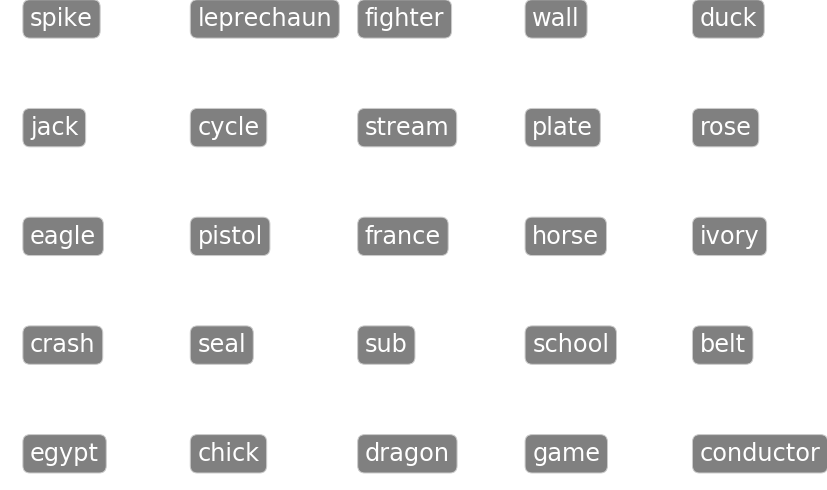

In [33]:
display(words)

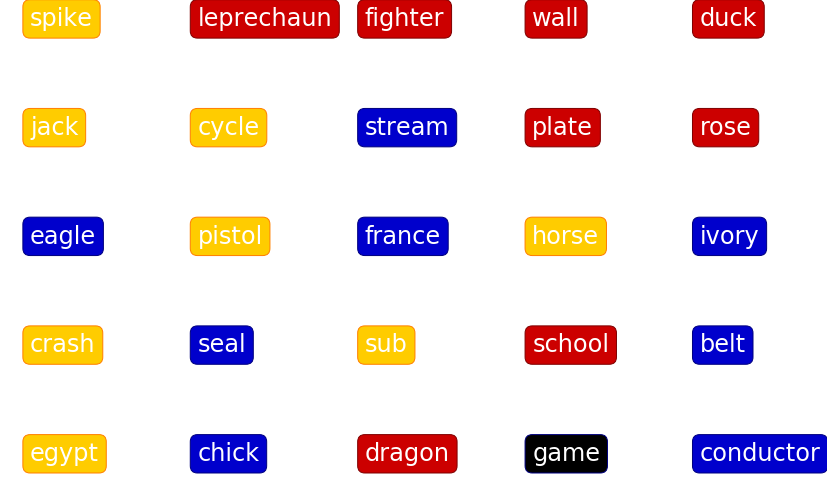

In [34]:
display(words, reveal=True)

We'll create a new grid, since we already looked at the game.

In [35]:
words, alignment = get_random_word_tiles(word_tiles, 25), get_random_tile_assignments()
w2c, c2wi = get_word_to_tile_assignment(words, alignment)

### Our Rules
* 'AI' is spymaster. We are team members on the red team.
* See how the AI does to help us guess the right answer

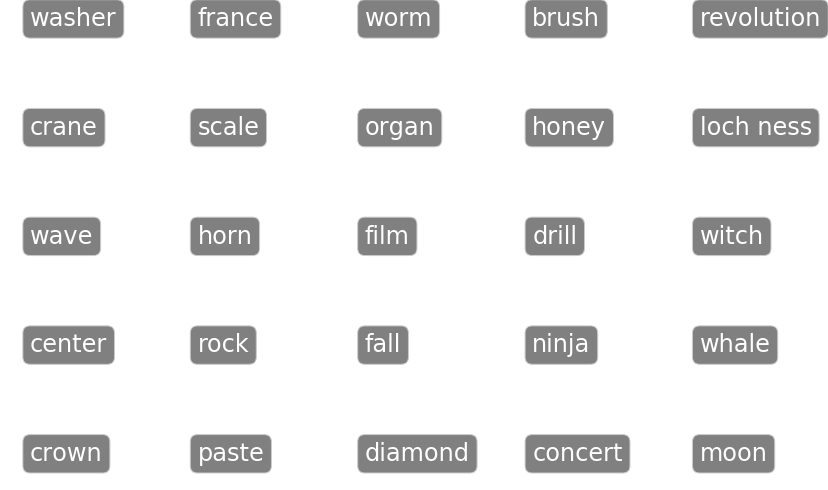

In [36]:
#here's the new grid don't worry we'll come back to it

display(words)

Now the let AI think

In [37]:
import itertools
k=1000
tile_colors = ["Red", "Blue", "Yellow", "Black"]
turn = "Red"
adverserial_colors = list(set(tile_colors) - set([turn]))
color_associations = {color : {word:get_knn(vocab, k, word) for word in words[c2wi[color]]} for color in tile_colors}
adversarial_associations = set(itertools.chain.from_iterable([color_associations[color] for color in adverserial_colors]))
turn_associations = {k:[a for a in v if a not in adversarial_associations] for (k,v) in color_associations[turn].items()}

Some more thinking

In [38]:
def intersection(*args):
    def intersect(a, b):
        return [word for word in a if word in b]
    intersected = args[0]
    for word_list in args[1:]:
        intersected = intersect(intersected, word_list)
    return intersected

# remove from clues words that are wholly contained in the word_combo
def sanitize(clues, word_combo):
    def is_stem_word(clue, word_combo):
        return [word for word in word_combo if clue in word or word in clue]
    clues = [clue for clue in clues if not is_stem_word(clue, word_combo)]
    return clues

def get_word_diff(vocab, w1, w2):
    def normalize(embed):
        return embed/embed.norm(ord=2)
    return nd.dot(normalize(vocab.embedding[w1]), normalize(vocab.embedding[w2])).asscalar()
    
def get_word_associations_metric(diffs):
    n = len(diffs)
    return (0.85**(n-1))*sum(diffs)*(n+1)/n

def get_word_combinations(turn_words):
    return list(itertools.chain.from_iterable(list(itertools.combinations(turn_words, r)) 
                                              for r in range(1, len(turn_words)+1)))

def get_value_for_word_combo(word_combo):
    clues = [turn_associations[word] for word in word_combo]
    if len(word_combo) > 1:
        common_clues = sanitize(intersection(*clues), word_combo)
        if not common_clues:
            return 0, clues[0][0]
        values = [get_word_associations_metric([get_word_diff(vocab, word, clue) for word in word_combo]) for clue in common_clues]
        idx = np.argmax(values)
        return values[idx], common_clues[idx]
    word = word_combo[0]
    clue = sanitize(turn_associations[word], word_combo)[0]
    return get_word_diff(vocab, word, clue), clue
    

AI: "I'm ready to give my clue"

In [39]:
word_combos = get_word_combinations(words[c2wi["Red"]])
combo_values = {word_combo:get_value_for_word_combo(word_combo) for word_combo in word_combos}
best = max(combo_values, key=combo_values.get)
print("My clue is: {} for {}".format(combo_values[best][1], len(best)))

My clue is: beginning for 2


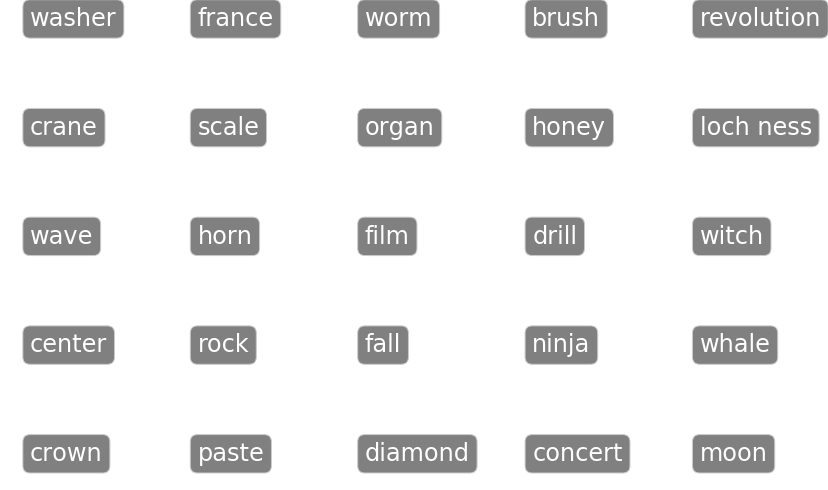

In [40]:
# let's return to the word grid:
display(words)

In [41]:
print(best)

('fall', 'revolution')


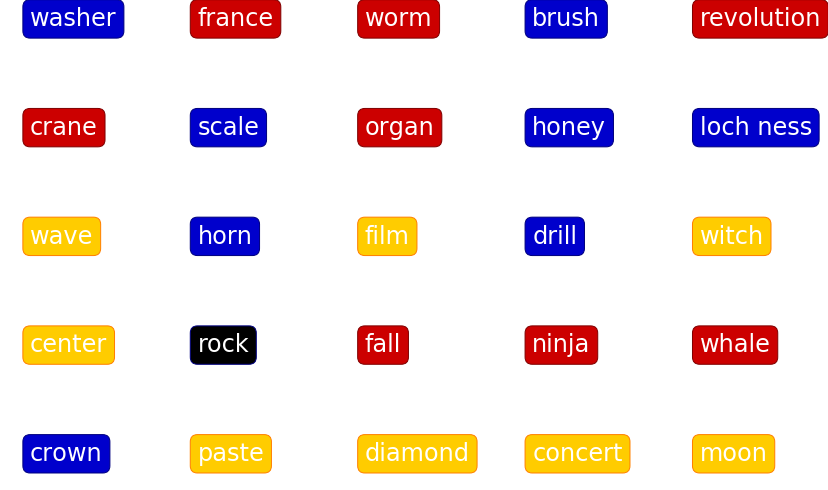

In [42]:
display(words, reveal=True)

In [43]:
sort_order = sorted(combo_values, key=combo_values.__getitem__, reverse=True)
for order in sort_order[:10]:
    print(order, combo_values[order])

('fall', 'revolution') (1.8955758601427077, 'beginning')
('fall', 'france', 'revolution') (1.8763785235087074, 'beginning')
('ninja', 'whale', 'worm') (1.8572643804550169, 'monkey')
('fall', 'france') (1.8121514886617662, 'europe')
('whale', 'crane', 'worm') (1.7696610877911247, 'shark')
('ninja', 'whale', 'crane', 'worm') (1.7523202528199178, 'frog')
('whale', 'worm') (1.7410142898559569, 'shark')
('fall', 'organ', 'france', 'revolution') (1.7106915320549156, 'the')
('ninja', 'worm') (1.6894036352634432, 'monkey')
('fall', 'organ', 'revolution') (1.6782556718587873, 'created')


# Other Applications

- Language Modelling
- Neural Machine Translation
- Text classification